In [73]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
#import statsmodels.api as sm
import matplotlib
#from statsmodels.tsa.holtwinters import ExponentialSmoothing
#import pmdarima as pm

from sklearn.metrics import mean_squared_error
import holidays

warnings.filterwarnings("ignore")
# #plt.style.use('fivethirtyeight')

import pyflux as pf

In [48]:
uk_holidays = holidays.UnitedKingdom()

In [49]:
uk_holidays=[]
for ptr in holidays.UnitedKingdom(years = [2018,2019]).keys(): 
      uk_holidays.append(ptr)

us_holidays=[]
for ptr in holidays.US(years = [2018,2019]).keys(): 
      us_holidays.append(ptr)

In [26]:
Hist = pd.read_excel('/home/madhav/Documents/Cargo_Virgin_Atlantis/Historic and Future Bookings.xlsx',sheet_name='Data Historic Bookings')

In [27]:
Hist.columns

Index(['FLT_NUM', 'BRD_PNT', 'DEP_DATE', 'OFF_PNT', 'CREATED_DATE',
       'MVT_STS_CODE', 'NOT_RDY_IND', 'ORIG', 'DEST', 'MTH', 'BKD_DAY', 'DOW',
       'CUST_CODE', 'AWB', 'JRN_NUM', 'RBI', 'PROD_CODE', 'CMDTY_CODE',
       'AWB_PCS', 'AWB_CHG_WT', 'AWB_ACT_WT', 'AWB_VOL', 'ULD_RES_IND',
       'ITN_WT', 'ITN_VOL', 'CHG_WG', 'ENQ_IND', 'OFFLOD_CNTR', 'ITN_CNX',
       'RES_CNX', 'WEEK', 'YEAR'],
      dtype='object')

In [28]:
Hist['Route']= Hist['BRD_PNT']+'_'+Hist['OFF_PNT']

In [29]:
Hist_forecast= Hist[['DEP_DATE','Route','CHG_WG','BKD_DAY','DOW','WEEK']]

In [30]:
Hist_forecast.head()

,DEP_DATE,Route,CHG_WG,BKD_DAY,DOW,WEEK
0,2018-02-22,LHR_DXB,163.0,8,4,8
1,2018-12-01,LHR_JNB,100.0,10,6,48
2,2018-12-18,LHR_JNB,107.0,18,2,51
3,2018-03-14,LHR_DXB,71.0,5,3,11
4,2018-03-24,LHR_LOS,85.0,8,6,12


In [31]:
Hist_forecast.DEP_DATE.head()

0   2018-02-22
1   2018-12-01
2   2018-12-18
3   2018-03-14
4   2018-03-24
Name: DEP_DATE, dtype: datetime64[ns]

In [34]:
Hist_eda= Hist_forecast[Hist_forecast.DEP_DATE < '2019-01-01'].copy()
Hist_eda= Hist_forecast.groupby(['Route']).agg({'CHG_WG':np.average})
Hist_eda.reset_index(inplace=True)

In [36]:
Hist_eda.sort_values(by=['CHG_WG'],ascending=False).iloc[:10,:]

,Route,CHG_WG
16,LGW_SBD,182297.000000
4,LGW_ATL,180824.000000
15,LGW_MSP,121369.000000
42,LHR_MSP,95877.500000
10,LGW_LAS,10084.612748
20,LGW_XMN,7553.500000
1,GLA_MAN,4622.233333
36,LHR_LGW,4421.000000
5,LGW_BFS,4087.300000
46,LHR_XMN,3766.500000


In [37]:
Hist_eda1=Hist_forecast[Hist_forecast.DEP_DATE < '2019-01-01'].copy()

In [40]:
Hist_eda1.head()

,DEP_DATE,Route,CHG_WG,BKD_DAY,DOW,WEEK,weekday
0,2018-02-22,LHR_DXB,163.0,8,4,8,NaN
1,2018-12-01,LHR_JNB,100.0,10,6,48,NaN
2,2018-12-18,LHR_JNB,107.0,18,2,51,NaN
3,2018-03-14,LHR_DXB,71.0,5,3,11,NaN
4,2018-03-24,LHR_LOS,85.0,8,6,12,NaN


In [50]:
def variable_extract(Hist,route):
    Hist_route=Hist[Hist.Route==route]
    Hist_route['peak']=np.where(Hist_route['CHG_WG']>=30000,1,0)
    Hist_route.reset_index(inplace=True)
    Hist_route['week']=Hist_route['DEP_DATE'].dt.week
    Hist_route['day_of_week']=Hist_route['DEP_DATE'].dt.dayofweek
    Hist['weekday'] = ((Hist_route['day_of_week'])// 5 == 1).astype(int)
    Hist_route['month']=Hist_route['DEP_DATE'].dt.month
    Hist_route['uk_holidays'] = Hist_route.index.isin(uk_holidays).astype('int')
    Hist_route['us_holidays'] = Hist_route.index.isin(us_holidays).astype('int')
    
    return Hist_route

In [51]:
Hist_LGW_SBD=variable_extract(Hist_eda1,'LGW_SBD')

In [52]:
Hist_LGW_SBD.head()

,index,DEP_DATE,Route,CHG_WG,BKD_DAY,DOW,WEEK,weekday,peak,week,day_of_week,month,uk_holidays,us_holidays


In [54]:
Hist_LGW_SBD.to_excel("/home/madhav/Documents/Cargo_Virgin_Atlantis/LGW_SBD.xlsx")

In [56]:
Hist_forecast1=Hist_forecast.groupby(['DEP_DATE','Route','BKD_DAY']).agg({'CHG_WG':np.sum})
Hist_forecast1.reset_index(inplace=True)

In [57]:
Hist_LGW_MBJ = Hist_forecast1[Hist_forecast1.Route=="LGW_MBJ"]

In [59]:
Hist_LHR_BOS = Hist_forecast1[Hist_forecast1.Route=="LHR_BOS"]

In [60]:
Hist_LHR_BOS.head()

,DEP_DATE,Route,BKD_DAY,CHG_WG
20,2018-01-01,LHR_BOS,3,455.0
21,2018-01-01,LHR_BOS,4,128.0
22,2018-01-01,LHR_BOS,12,1277.0
23,2018-01-01,LHR_BOS,13,937.0
144,2018-01-02,LHR_BOS,12,14639.0


In [61]:
df_LHR_BOS=Hist_LHR_BOS.set_index("DEP_DATE")

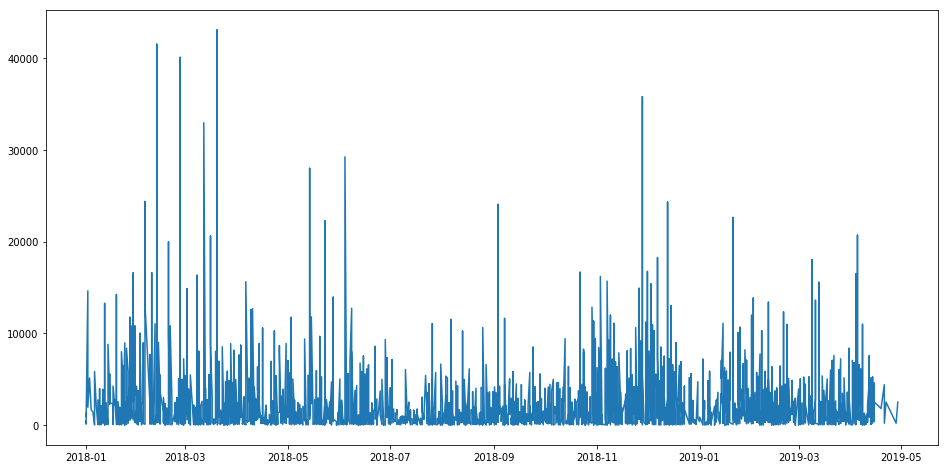

In [62]:
plt.figure(figsize=(16,8))
plt.plot(df_LHR_BOS["CHG_WG"])

In [63]:
df_LHR_BOS['peak']=np.where(df_LHR_BOS['CHG_WG']>=30000,1,0)

In [64]:
df_LHR_BOS.reset_index(inplace=True)

In [65]:
df_LHR_BOS['week']=df_LHR_BOS['DEP_DATE'].dt.week
df_LHR_BOS['day_of_week']=df_LHR_BOS['DEP_DATE'].dt.dayofweek
df_LHR_BOS['weekday']=df_LHR_BOS['DEP_DATE'].dt.weekday
df_LHR_BOS['month']=df_LHR_BOS['DEP_DATE'].dt.month

In [67]:
for ptr in holidays.US(years = [2018,2019]).items(): 
      print(ptr)

(datetime.date(2018, 1, 1), "New Year's Day")
(datetime.date(2018, 1, 15), 'Martin Luther King, Jr. Day')
(datetime.date(2018, 2, 19), "Washington's Birthday")
(datetime.date(2018, 5, 28), 'Memorial Day')
(datetime.date(2018, 7, 4), 'Independence Day')
(datetime.date(2018, 9, 3), 'Labor Day')
(datetime.date(2018, 10, 8), 'Columbus Day')
(datetime.date(2018, 11, 11), 'Veterans Day')
(datetime.date(2018, 11, 12), 'Veterans Day (Observed)')
(datetime.date(2018, 11, 22), 'Thanksgiving')
(datetime.date(2018, 12, 25), 'Christmas Day')
(datetime.date(2019, 1, 1), "New Year's Day")
(datetime.date(2019, 1, 21), 'Martin Luther King, Jr. Day')
(datetime.date(2019, 2, 18), "Washington's Birthday")
(datetime.date(2019, 5, 27), 'Memorial Day')
(datetime.date(2019, 7, 4), 'Independence Day')
(datetime.date(2019, 9, 2), 'Labor Day')
(datetime.date(2019, 10, 14), 'Columbus Day')
(datetime.date(2019, 11, 11), 'Veterans Day')
(datetime.date(2019, 11, 28), 'Thanksgiving')
(datetime.date(2019, 12, 25), 'Ch

In [69]:
df_LHR_BOS['uk_holidays'] = df_LHR_BOS.index.isin(uk_holidays).astype('int')
df_LHR_BOS['us_holidays'] = df_LHR_BOS.index.isin(us_holidays).astype('int')

In [70]:
df_LHR_BOS.head(10)

,DEP_DATE,Route,BKD_DAY,CHG_WG,peak,week,day_of_week,weekday,month,uk_holidays,us_holidays
0,2018-01-01,LHR_BOS,3,455.0,0,1,0,0,1,0,0
1,2018-01-01,LHR_BOS,4,128.0,0,1,0,0,1,0,0
2,2018-01-01,LHR_BOS,12,1277.0,0,1,0,0,1,0,0
3,2018-01-01,LHR_BOS,13,937.0,0,1,0,0,1,0,0
4,2018-01-02,LHR_BOS,12,14639.0,0,1,1,1,1,0,0
5,2018-01-02,LHR_BOS,13,1934.5,0,1,1,1,1,0,0
6,2018-01-03,LHR_BOS,14,5134.0,0,1,2,2,1,0,0
7,2018-01-04,LHR_BOS,2,1666.5,0,1,3,3,1,0,0
8,2018-01-05,LHR_BOS,7,1428.0,0,1,4,4,1,0,0
9,2018-01-06,LHR_BOS,1,27.5,0,1,5,5,1,0,0


In [75]:
df_LHR_BOS1 = df_LHR_BOS.groupby(['DEP_DATE','peak','week','day_of_week','weekday','month','uk_holidays','us_holidays','BKD_DAY']).agg({'CHG_WG':np.sum})
df_LHR_BOS1.reset_index(inplace=True)

In [98]:
df_LHR_BOS1 = df_LHR_BOS.groupby(['DEP_DATE','day_of_week','month','uk_holidays','us_holidays','peak','week','weekday']).agg({'CHG_WG':np.sum})
df_LHR_BOS1.reset_index(inplace=True)

In [99]:
df_LHR_BOS1.head()

,DEP_DATE,day_of_week,month,uk_holidays,us_holidays,peak,week,weekday,CHG_WG
0,2018-01-01,0,1,0,0,0,1,0,2797.0
1,2018-01-02,1,1,0,0,0,1,1,16573.5
2,2018-01-03,2,1,0,0,0,1,2,5134.0
3,2018-01-04,3,1,0,0,0,1,3,1666.5
4,2018-01-05,4,1,0,0,0,1,4,1428.0


In [101]:
#df_LHR_BOS1.to_excel('/home/madhav/Documents/Cargo_Virgin_Atlantis/LHR_BOS.xlsx')

In [100]:
model = pf.ARIMAX(data =df_LHR_BOS1 , formula='CHG_WG ~ 1+day_of_week+month+uk_holidays+us_holidays+peak+week+weekday',
                  ar=1,ma=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Hessian not invertible! Consider a different model specification.

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: CHG_WG                              Method: MLE                                       
Start Date: 1                                           Log Likelihood: -4919.2149                        
End Date: 464                                           AIC: 9860.42972355323                             
Number of observations: 464                             BIC: 9905.96845362772                             
Latent Variable                          Estimate  
======================================== ==========
AR(1)                                    0.997     
MA(1)                                    -0.8992   
Beta 1                                   0.0005    
Beta day_of_week               